In [1]:
import os
import matplotlib.pyplot as plt
import skimage
import numpy as np
from scipy import ndimage as ndi
from skimage import io
import pandas as pd
from pygrowthmodels import vonbertalanffy
import scipy
import cv2

# TODO:
    suavizar aneis
    confirmar se perfis estao bem traçados

In [134]:
dados = pd.DataFrame()
# importa nome dos ficheiros
lista = []
for file in os.listdir('photos/bios'):
    lista.append(file)
dados['file'] = lista
# extrai atributos dos ficheiros com base nos nomes
res = []
for name in dados['file']:
    res.append(name.split('-'))

dados['Lt'] = [item[5] for item in res]
dados['Lt'] = dados['Lt'].apply(lambda x: float(x.split()[0].replace(',','.')))
dados['month'] = [item[3][2:5] for item in res]
dados['semester'] = ['S1' if month in ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun'] else 'S2' for month in dados['month']]
# prepara idades
dados['age'] = 0
#limpeza
del lista, res

In [95]:
print(dados)

                                             file    Lt month semester  age
0       GUU-Deneb-Amo2-21Jan08-100-25,4-2-0,5.jpg  25.4   Jan       S1    0
1       GUU-Deneb-Amo2-21Jan08-101-25,2-2-0,5.jpg  25.2   Jan       S1    0
2         GUU-Deneb-Amo2-21Jan08-102-25-2-0,5.jpg  25.0   Jan       S1    0
3       GUU-Deneb-Amo2-21Jan08-103-26,1-2-0,5.jpg  26.1   Jan       S1    0
4     GUU-Deneb-Amo2-21Jan08-104-26,2-1,6-0,5.jpg  26.2   Jan       S1    0
..                                            ...   ...   ...      ...  ...
696  GUU-MardeLagos-Amo1-07Jan08-5-21,7-2-0,5.jpg  21.7   Jan       S1    0
697  GUU-MardeLagos-Amo1-07Jan08-6-21,9-2-0,5.jpg  21.9   Jan       S1    0
698  GUU-MardeLagos-Amo1-07Jan08-7-21,3-2-0,5.jpg  21.3   Jan       S1    0
699  GUU-MardeLagos-Amo1-07Jan08-8-21,6-2-0,5.jpg  21.6   Jan       S1    0
700  GUU-MardeLagos-Amo1-07Jan08-9-21,5-2-0,5.jpg  21.5   Jan       S1    0

[701 rows x 5 columns]


In [4]:
teste_01 = io.imread('photos/bios/GUU-Draco-Amo9-29Mai70-515-29,1-2-0,5-DIR.jpg')
teste_02 = io.imread('photos/bios/GUU-Mar Roxo-Amo4-27Fev08-202-23,4-2,5-0,5-ESQ.jpg')
teste_03 = io.imread('photos/AM3 CL_20112018/CL19_20112018.jpg')
teste_04 = io.imread('photos/NOVAS FOTOS/0004.tif', plugin='pil')
teste_05 = io.imread('photos/bios/GUU-Deneb-Amo2-21Jan08-49-20,9-2-0,5.jpg')

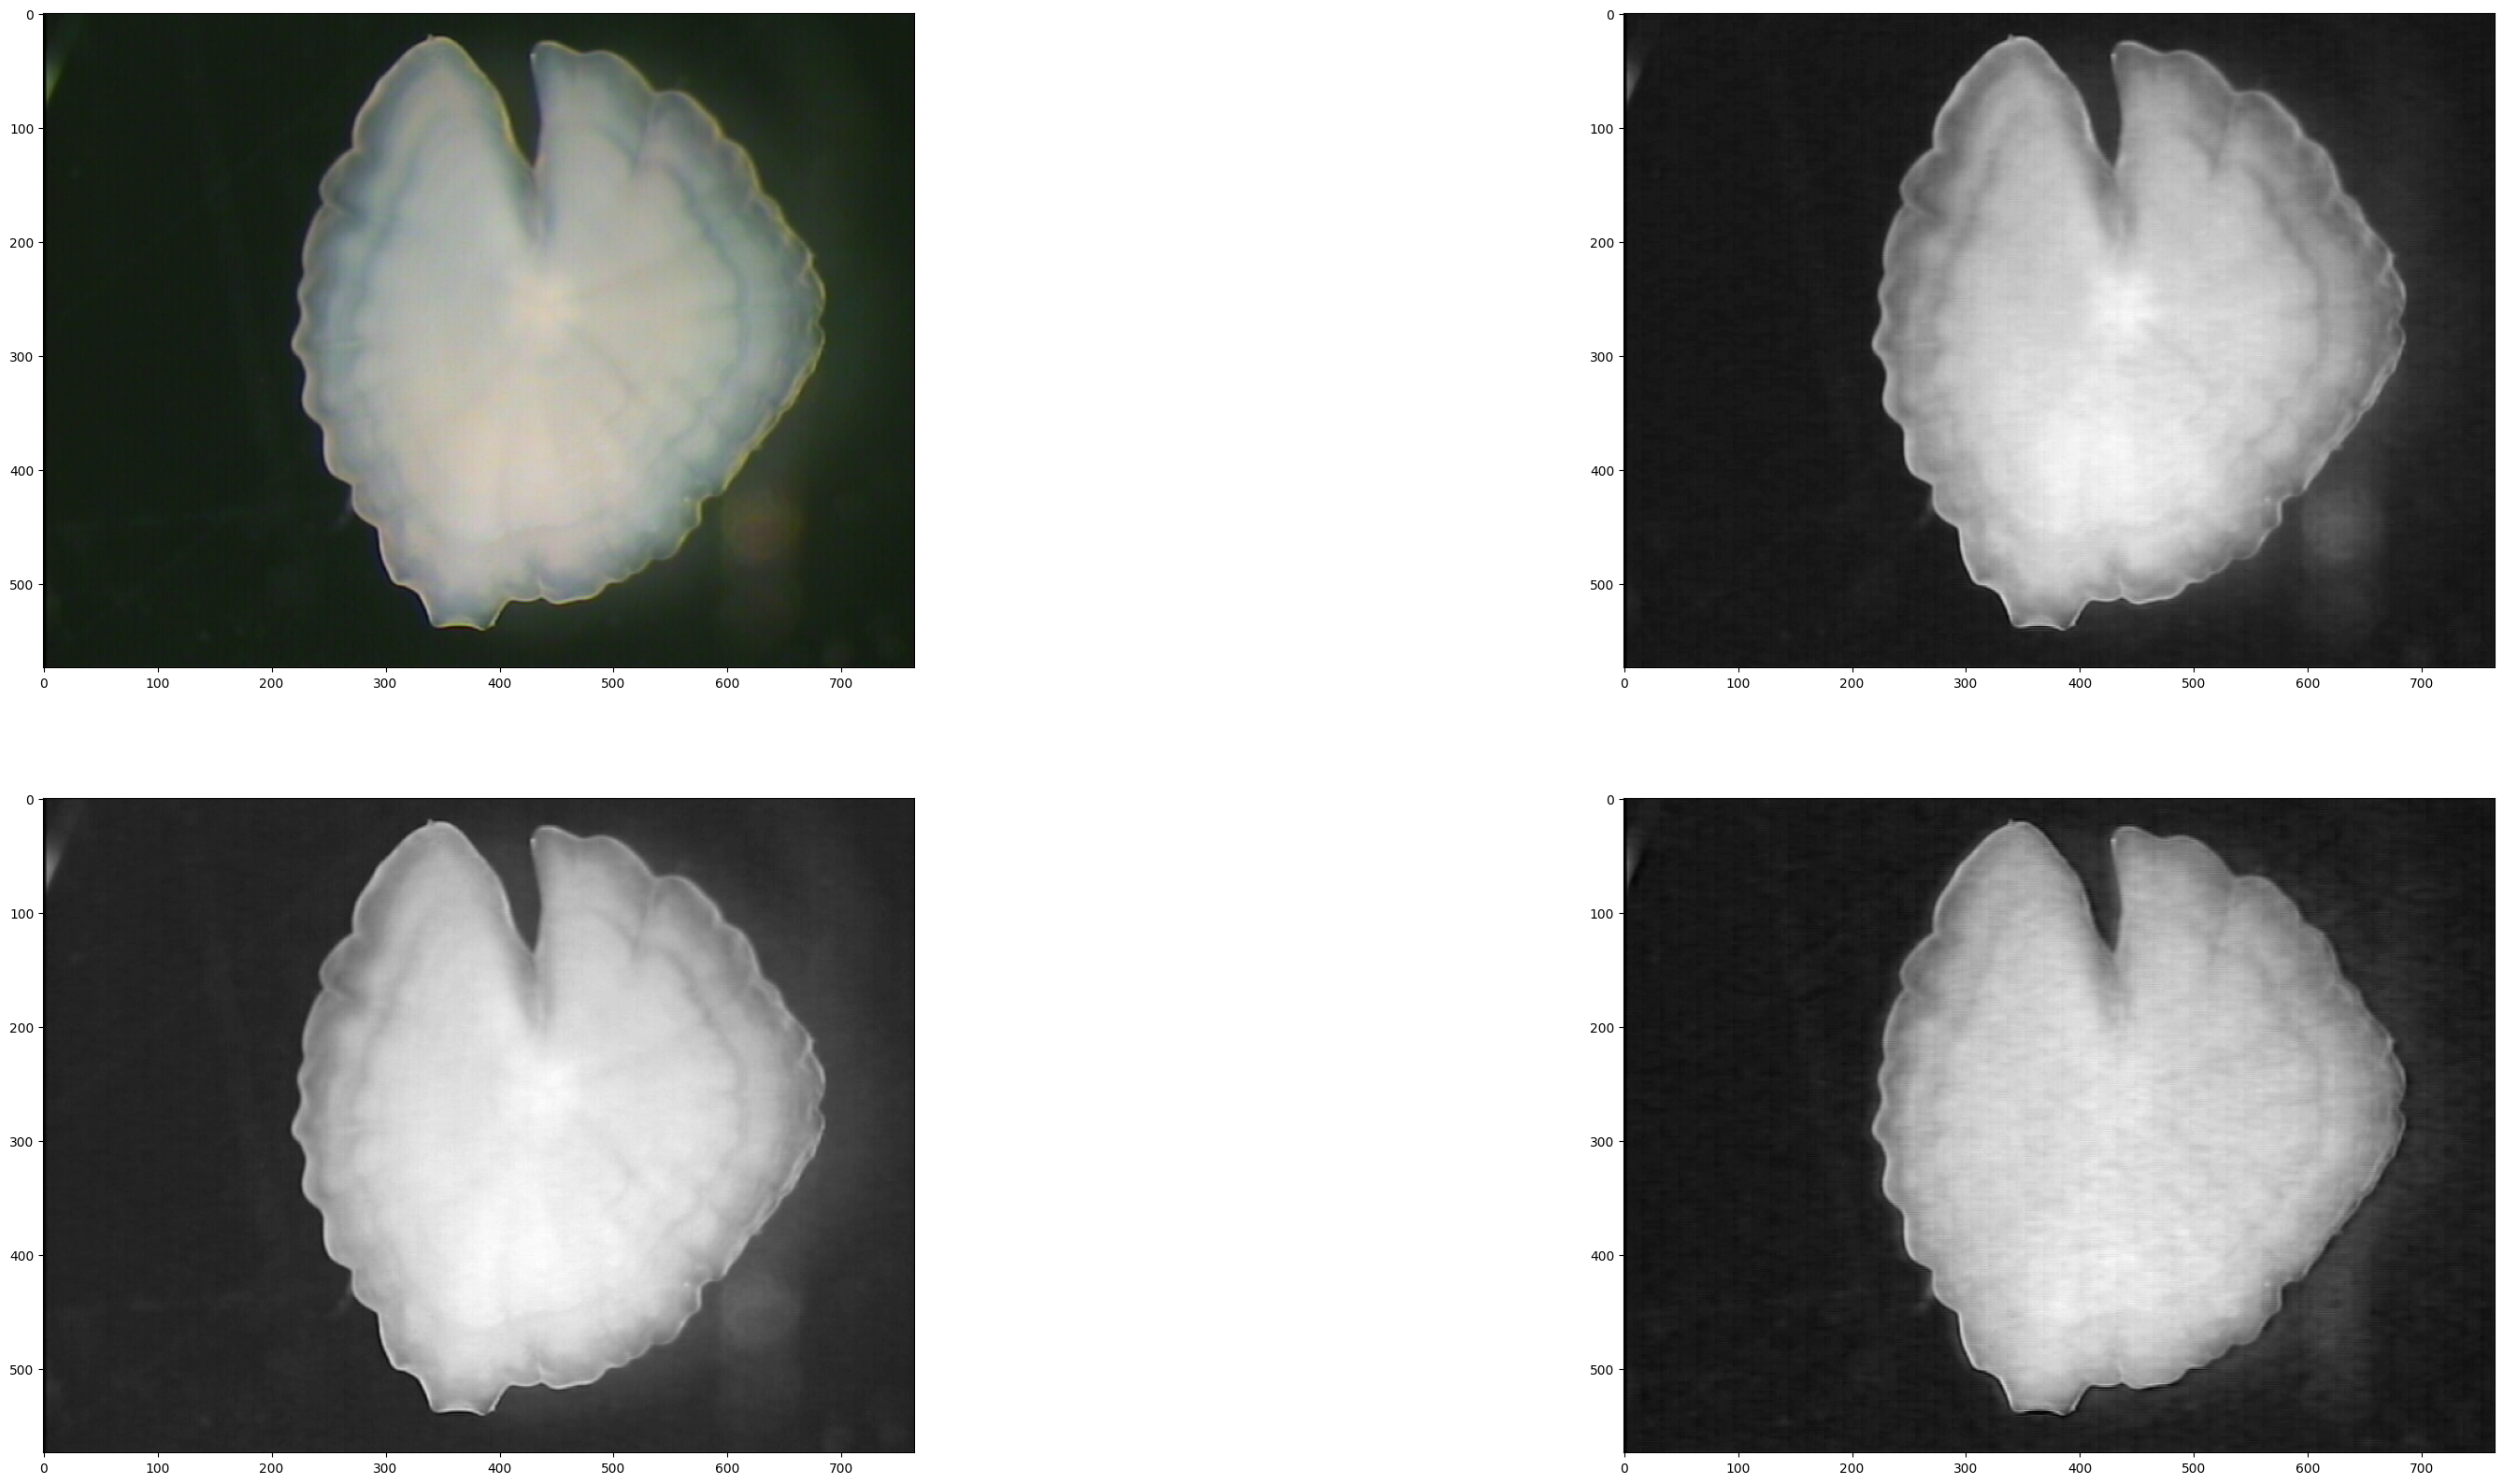

In [5]:
img = io.imread(('photos/bios/'+dados['file'][300]))
f, ax = plt.subplots(2,2, figsize = (40,20))
ax[0,0].imshow(img)
ax[0,1].imshow(img[:,:,0], cmap = plt.cm.gray)
ax[1,0].imshow(img[:,:,1], cmap = plt.cm.gray)
ax[1,1].imshow(img[:,:,2], cmap = plt.cm.gray)

# Função: Prototipo 1:

In [52]:
def suavizador(perfil:list, h=3):
    res = np.convolve(perfil, np.ones(h), "valid")/h
    return res

# primeira derivada
def deriv_1(perfil):
    res = []
    for i in range(1,np.shape(perfil)[0]-1):
        res.append((perfil[i+1] - perfil[i-1])/2)
    trans = [np.sign(i) for i in res]
    return res # antes tinha aqui trans
# segunda derivada
def deriv_2(perfil):
    res = []
    for i in range(2,np.shape(perfil)[0]-2):
        res.append((perfil[i] + perfil[i+1] - perfil[i-1] - perfil[i-2])/4)
    trans = [np.sign(i) for i in res]
    return trans
# terceira derivada
def deriv_3(perfil):
    res = []
    for i in range(3,np.shape(perfil)[0]-3):
        res.append((perfil[i] + perfil[i+1] + perfil[i+2] - perfil[i-1] - perfil[i-2] - perfil[i-3])/4)
    trans = [np.sign(i) for i in res]
    return trans

def conta_transicoes(trans:list):
    trans_b = []
    dist = [0]
    for i in range(1, np.shape(trans)[0]-1):
        if trans[i+1] > 0 and trans[i] < 0:
            trans_b.append('H -> O')
            dist.append(i)
        elif trans[i+1] < 0 and trans[i] > 0:
            trans_b.append('O -> H')
    trans_limpo = [item for item in trans_b if item == 'H->0']
    # bordo
    bordo = trans_b[-1]
    return trans_limpo, dist, bordo

def drop_falsos(lista:list):
    lista
    for i, j in zip(lista, lista[1:]):
        if i < j:
            lista.remove(i)
    return lista


Hiperparametros:
    * Plot: True / False
    * Kernel do Gaussian Blur
    * Amplitude de suavização do perfil
    * layer: Usar imagem colapsada ou canal vermelho
    * perfil: usar imagem original ou versao hpf
    * Ordem de derivação do perfil - Por implementar

In [131]:
def processador(imagem, plot:bool=True, semester = 'S1', kernel:int = 101, smooth:int = 3, layer:str = "raw", perfil:str = 'raw'):

    if layer == 'raw':
        colapsado = skimage.color.rgb2gray(imagem)
    elif layer == 'red':
        colapsado = imagem[:,:,0]

    # prepara histograma para desenhar imagem
    histogram, bin_edges = np.histogram(colapsado, bins=100, range=(0, 1))

    # detecta a borda e cria uma mascara
    markers = np.zeros_like(colapsado)
    markers[colapsado < 0.1] = 1 # como determinar este valor?
    markers[colapsado> 0.8] = 2 # como determinar este valor?

    edge = skimage.filters.sobel(colapsado)
    segmentation_edge = skimage.segmentation.watershed(edge, markers)

    # limpeza do segmentation edge
    mascara = segmentation_edge-1

    # identifica o objecto maior
    otolito = skimage.filters.apply_hysteresis_threshold(colapsado*segmentation_edge, high = 0.6, low = 0.4) # validar valores
    labeled = ndi.label(otolito)[0]
    otolito = skimage.color.label2rgb(labeled, mascara)

    # identifica o centroide
    largest_nonzero_label = np.argmax(np.bincount(labeled[labeled > 0]))
    binary = labeled == largest_nonzero_label
    skeleton = skimage.morphology.skeletonize(binary)
    g, nodes = skimage.graph.pixel_graph(skeleton, connectivity=2)
    px, distances = skimage.graph.central_pixel(
    g, nodes=nodes, shape=skeleton.shape, partition_size=100)

    centroid = skimage.measure.centroid(labeled > 0)

    # identifica a borda pixel a pixel?
    borda = skimage.measure.find_contours(binary) # em vez de segmentation edge?

    # calcula extremo do rostro
    origin_x, origin_y = px[1], px[0]
    res = []
    for array in borda:
        for line in array:
            res.append(line.tolist())

    distancia = []
    for item in res:
        distancia.append(np.sqrt((origin_y-item[1])**2 + (origin_x-item[0])**2))
    max_index = distancia.index(max(distancia))
    extremo = res[max_index]

    # Versao smoothed da imagem
    hpf = colapsado - cv2.GaussianBlur(colapsado,(kernel,kernel),0)

    # linha de perfil a partir do centroide - pode ser feita a partir do colapsado ou do hpf
    profile = skimage.measure.profile_line(colapsado, src = (origin_y, origin_x), dst = (extremo[0],extremo[1]))
    profile_hpf = skimage.measure.profile_line(hpf, src = (origin_y, origin_x), dst = (extremo[0],extremo[1]))

    # histograma do perfil; intuiçao para smoothing
    p_hist, p_bin = np.histogram(profile, bins=255, range=(0, 1))

    #contagem de aneis
    if perfil == 'raw':
        smoothed = suavizador(profile, smooth)
    else:
        smoothed = suavizador(profile_hpf, smooth)

    smoothed_deriv = deriv_1(smoothed)

    res = conta_transicoes(smoothed_deriv)
    diff = [res[1][indice+1] - res[1][indice] for indice in range(len(res[1])-1)]

    nova_diff = diff.copy()
    contador = 0
    while contador < len(diff):
        drop_falsos(nova_diff)
        contador += 1

    if res[2] == 'O-H' and semester == 'S1':
        bordo = 1
    else:
        bordo = 0

    age = len(nova_diff) + bordo

    # visualização de alguns picos
    picos = scipy.signal.find_peaks(smoothed, prominence = 0.012) # manipular distance e width
    vales = scipy.signal.find_peaks(smoothed*-1, prominence = 0.012)

    # plots
    if plot:
        f, ax = plt.subplots(3,3, figsize = (40,20))
        # imagem original em grayscale
        ax[0,0].imshow(colapsado, cmap = plt.cm.gray)
        # imagem original depois de retirar o fundo por watershed
        ax[0,1].imshow(colapsado * mascara, cmap = plt.cm.gray)
        # histograma da imagem original
        ax[0,2].plot(bin_edges[0:-1], histogram)
        # regiao do otolito determinada por hysteresis
        ax[1,0].imshow(otolito, cmap = plt.cm.gray)
        # centroide, borda e linha de perfil do otolito

        origin = [origin_x, extremo[1]]
        dest = [origin_y,extremo[0]]

        # avaliaç

        #ax[1,1].imshow(skimage.color.label2rgb(skeleton, colapsado*mascara)) # versao original com mascara
        ax[1,1].imshow(colapsado, cmap = plt.cm.gray)
        ax[1,1].plot(origin, dest, linewidth = 5, color = 'r')
        ax[1,1].scatter(px[1], px[0], label='graph center')
        ax[1,1].scatter(centroid[1], centroid[0], label='centroid')
        ax[1,1].legend()
        ax[1,1].set_axis_off()
        ax[1,1].set_title('graph center vs centroid')
        for contour in borda:
            ax[1,1].plot(contour[:, 1], contour[:, 0], linewidth=4, color = 'r')

        # perfil desenhado do otolito
        ax[1,2].plot(profile)
        # histograma do perfil
        #ax[2,0].plot(p_bin[0:-1], p_hist)

        ax[2,1].imshow(hpf, cmap = plt.cm.gray)
        ax[2,1].plot(origin, dest, linewidth = 5, color = 'r')
        ax[2,1].scatter(px[1], px[0], label='graph center')
        ax[2,1].scatter(centroid[1], centroid[0], label='centroid')
        ax[2,1].legend()
        ax[2,1].set_axis_off()
        ax[2,1].set_title('graph center vs centroid')
        for contour in borda:
            ax[2,1].plot(contour[:, 1], contour[:, 0], linewidth=4, color = 'r')

        ax[2,2].plot(profile_hpf)
        # histograma do perfil
        #ax[2,0].plot(p_bin[0:-1], p_hist)

        ax[2,0].plot(smoothed)
        for pico in picos[0]:
            ax[2,0].vlines(x = pico, ymin = smoothed.min(), ymax= smoothed.max(), color = 'r')
        for vale in vales[0]:
            ax[2,0].vlines(x = vale, ymin = smoothed.min(), ymax= smoothed.max(), color = 'g')

    print(res[1])
    print(f'existem {len(nova_diff)} aneis hialinos; idade estimada é {age} e o bordo é {bordo}')
    return age
    #return age, bordo, res[1], diff, nova_diff

existem 3 aneis hialinos; idade estimada é 3


3

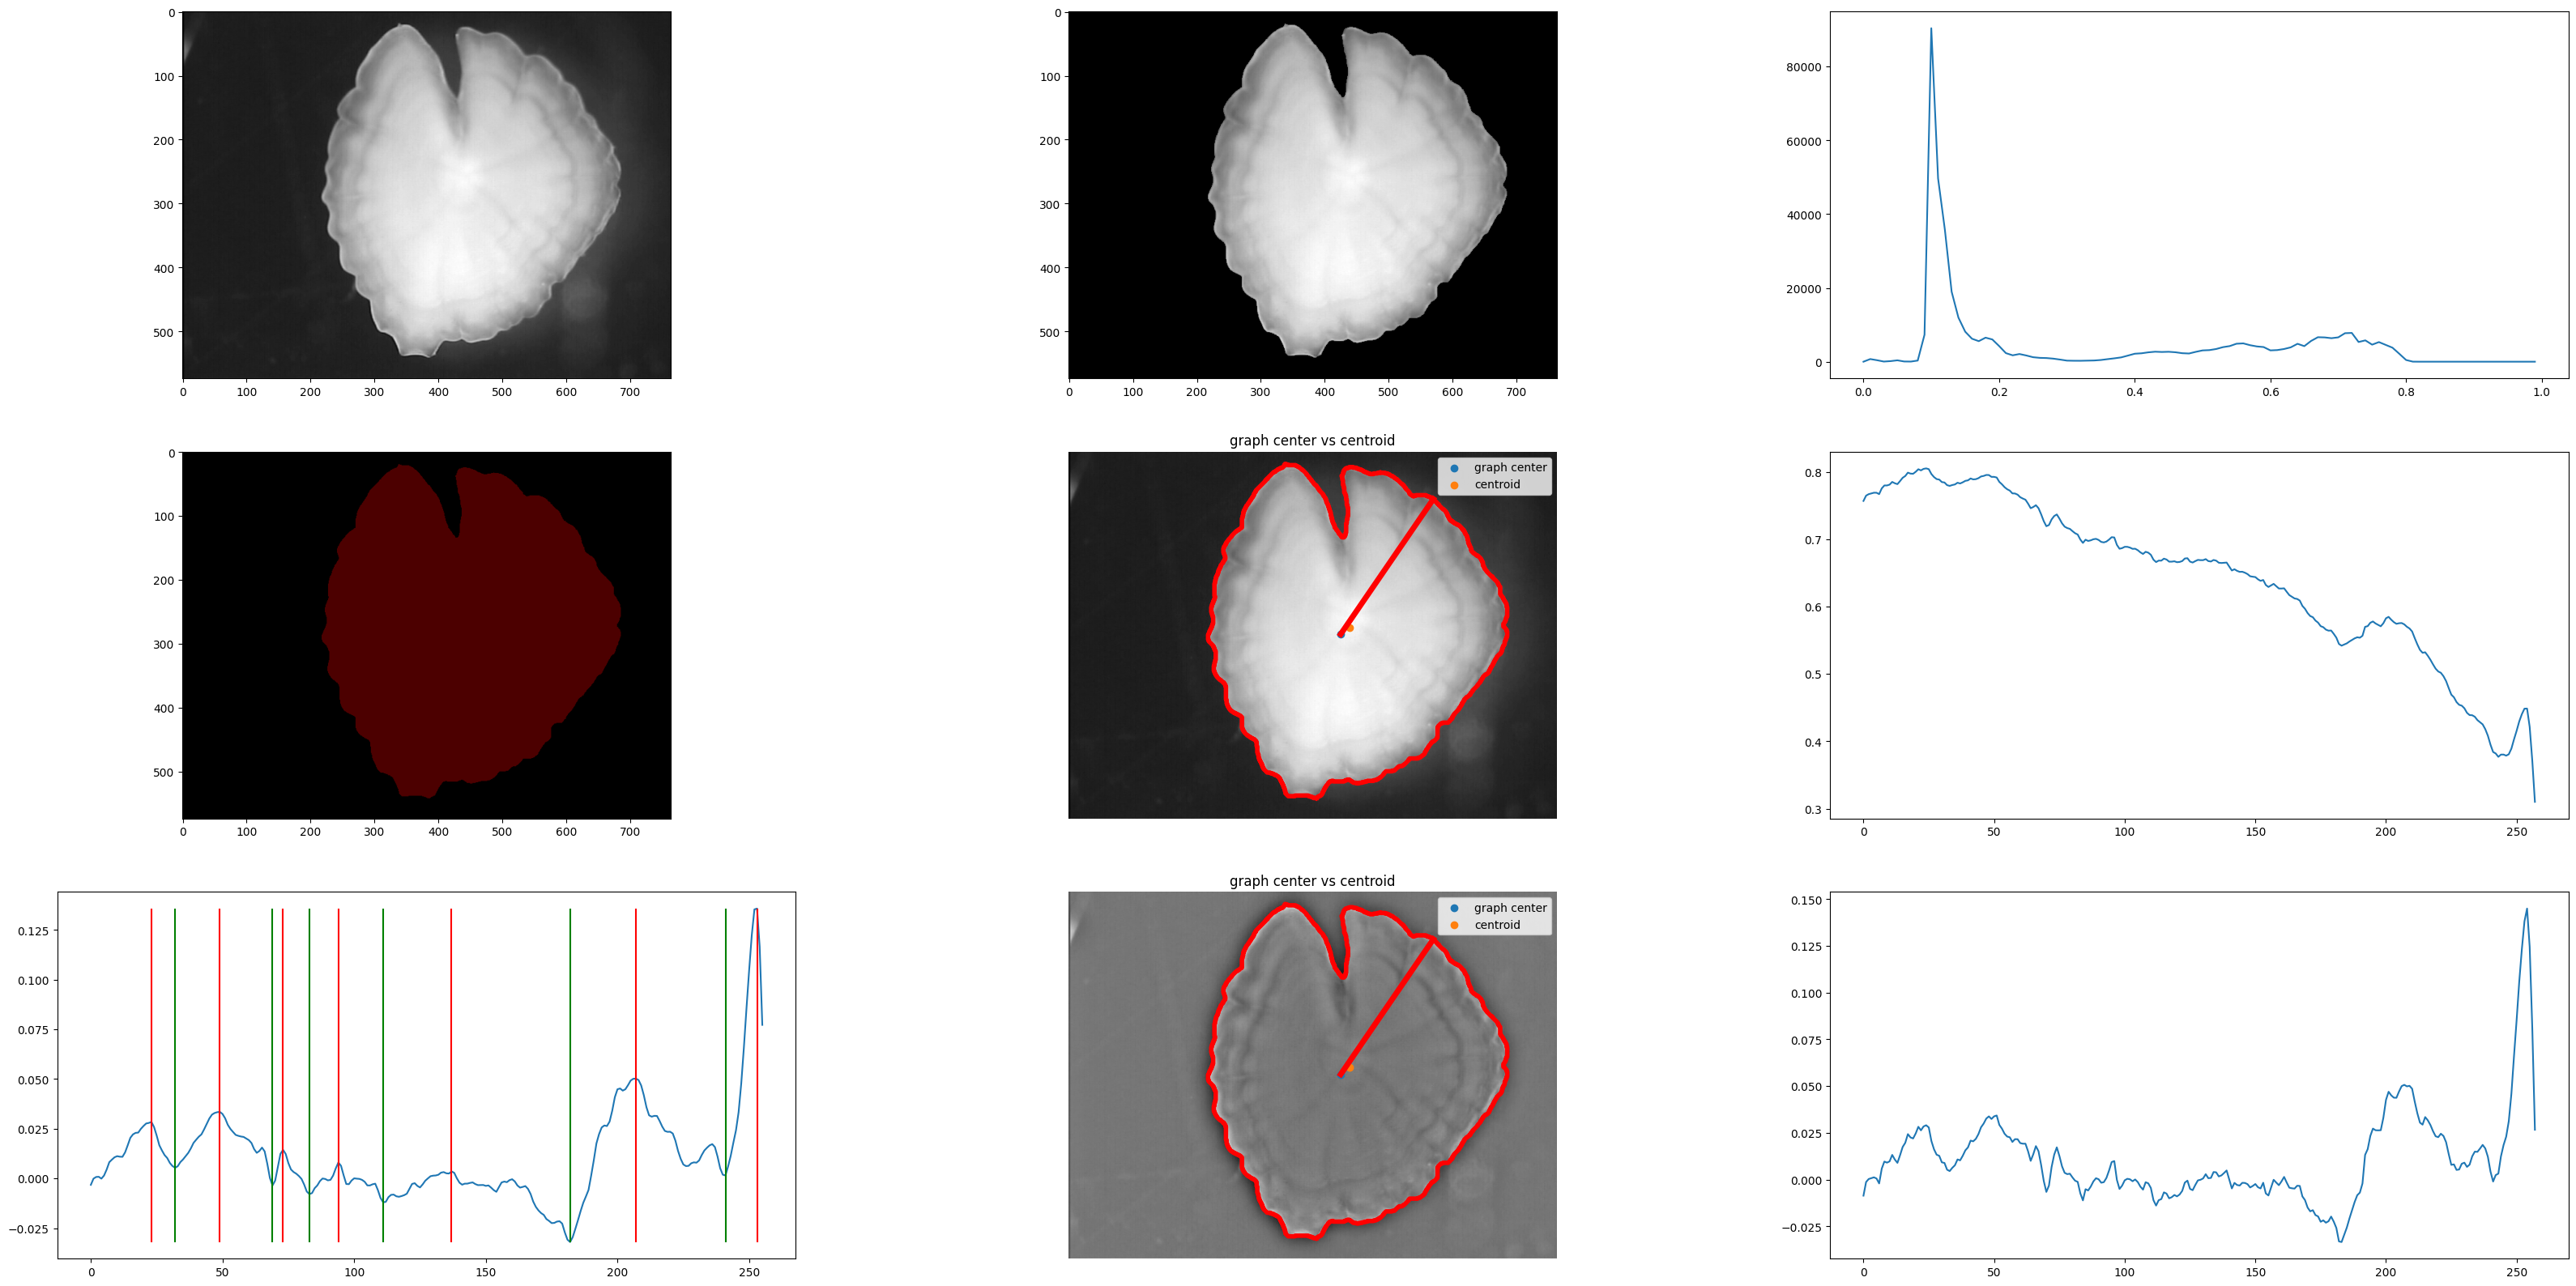

In [71]:
processador(io.imread(('photos/bios/'+dados['file'][300])), True)

https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html
http://olgahernand.free.fr/gallery_scripts/html/figure_python/von_Bertalanffy_plots.html

# ensaio de contagem de aneis

In [136]:
leituras = []
for line in range(dados.shape[0]):
#for line in range(100):
    idade = processador(io.imread(('photos/bios/'+dados['file'][line])), False,
                        kernel = 151, smooth=7, layer = 'red', perfil = 'raw')
    leituras.append(idade)

[0, 20, 26, 31, 38, 49, 62, 71, 100, 102, 118, 140, 195, 215, 241, 264, 286, 308, 330]
existem 6 aneis hialinos; idade estimada é 6 e o bordo é 0
[0, 5, 63, 77, 89, 118, 141, 177, 197, 209, 221, 269, 299, 359]
existem 1 aneis hialinos; idade estimada é 1 e o bordo é 0
[0, 16, 44, 47, 82, 102, 108, 112, 124, 141, 151, 179, 201, 237, 264, 270, 323]
existem 1 aneis hialinos; idade estimada é 1 e o bordo é 0
[0, 29, 105, 118, 148, 170, 207, 227, 239, 262, 284, 312, 325, 333, 348, 355, 377]
existem 4 aneis hialinos; idade estimada é 4 e o bordo é 0
[0, 18, 37, 63, 88, 111, 123, 151, 213, 237, 284, 336, 346, 365, 380, 389]
existem 5 aneis hialinos; idade estimada é 5 e o bordo é 0
[0, 21, 61, 133, 154, 173, 179, 209, 229, 267, 297, 308, 343, 358, 376, 392]
existem 5 aneis hialinos; idade estimada é 5 e o bordo é 0
[0, 14, 40, 48, 115, 126, 146, 151, 208, 222, 228, 239, 248, 266, 284, 307, 323, 334, 352, 377, 385]
existem 4 aneis hialinos; idade estimada é 4 e o bordo é 0
[0, 5, 27, 80, 120, 

Validaçao e modelo de crescimento

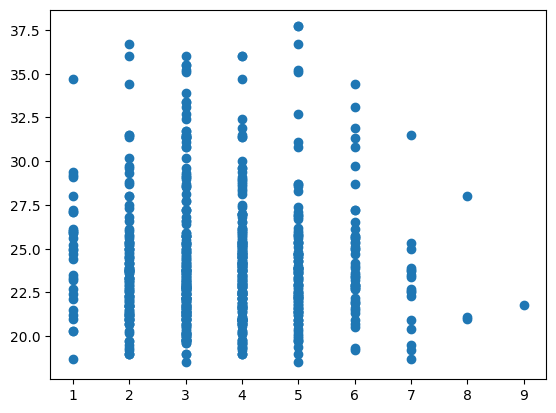

In [137]:
dados['age'] = leituras
#plt.scatter(dados['age'][0:100], dados['Lt'][0:100])
plt.scatter(dados['age'], dados['Lt'])

In [138]:
dados.to_csv('leituras.csv')